# Data preparation for *Nature* Herd Immunity news feature

We want to recreate this chart from [Our World In Data](https://ourworldindata.org/covid-vaccinations), using the downloadabel CSV file that they provide.

## Load the packages we will need

In [1]:
library(DT)

In [2]:
library(repr)

In [3]:
library(readr)

In [4]:
library(dplyr, warn.conflicts = FALSE)

In [5]:
library(ggplot2)

In [6]:
library(scales, warn.conflicts = FALSE)

In [7]:
library(lubridate, warn.conflicts = FALSE)

In [21]:
library(tidyr)

## Download the data

Load the data as CSV file from [Our World In Data](https://ourworldindata.org/covid-vaccinations)

In [8]:
df_csv <- read.csv("https://covid.ourworldindata.org/data/owid-covid-data.csv?v=2021-03-09", stringsAsFactors=F)

## Look at the data

In order to recreate the chart from Our World in Data, it looks like `total_vaccinations_per_hundred ` is the best bet.

[An example of how we calculate our metrics](https://github.com/owid/covid-19-data/tree/master/public/data/vaccinations#an-example-of-how-we-calculate-our-metrics) from the Our World In Data github repo.

In [9]:
head(df_csv)

iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
AFG,Asia,Afghanistan,2020-02-24,1,1,NA,NA,NA,NA,...,1803.987,NA,597.029,9.59,NA,NA,37.746,0.5,64.83,0.511
AFG,Asia,Afghanistan,2020-02-25,1,0,NA,NA,NA,NA,...,1803.987,NA,597.029,9.59,NA,NA,37.746,0.5,64.83,0.511
AFG,Asia,Afghanistan,2020-02-26,1,0,NA,NA,NA,NA,...,1803.987,NA,597.029,9.59,NA,NA,37.746,0.5,64.83,0.511
AFG,Asia,Afghanistan,2020-02-27,1,0,NA,NA,NA,NA,...,1803.987,NA,597.029,9.59,NA,NA,37.746,0.5,64.83,0.511
AFG,Asia,Afghanistan,2020-02-28,1,0,NA,NA,NA,NA,...,1803.987,NA,597.029,9.59,NA,NA,37.746,0.5,64.83,0.511
AFG,Asia,Afghanistan,2020-02-29,1,0,0.143,NA,NA,0,...,1803.987,NA,597.029,9.59,NA,NA,37.746,0.5,64.83,0.511


## Cumulative COVID-19 vaccination dose administered per 100 people over time

###  Filter and format the data

Let's extract just the country codes, names, dates and total vaccinations per hundred.

And reduce the list of countries to just the ones we want to show.

The filter to just show dates in 2021.

In [10]:
countries_to_show <- c(
"Israel",
"United States",
"Serbia",
"United Kingdom",
"Brazil",    
"China",
"India",
"World"
)

In [11]:
df_formatted <- df_csv %>%
    # Reduce to just the columns that we want
    select(iso_code, location, date, total_vaccinations_per_hundred) %>%
    # Format the dates as actual dates, rather than strings
    mutate(date_formatted = ymd(date)) %>%
    # Cut out any dates before 2021
    filter(date_formatted > "2020-12-31") %>%
    # Cut out any country that's not in the list
    subset( location %in% countries_to_show)

### Plot a chart of the result

Warning message:
“Removed 56 rows containing missing values (geom_path).”

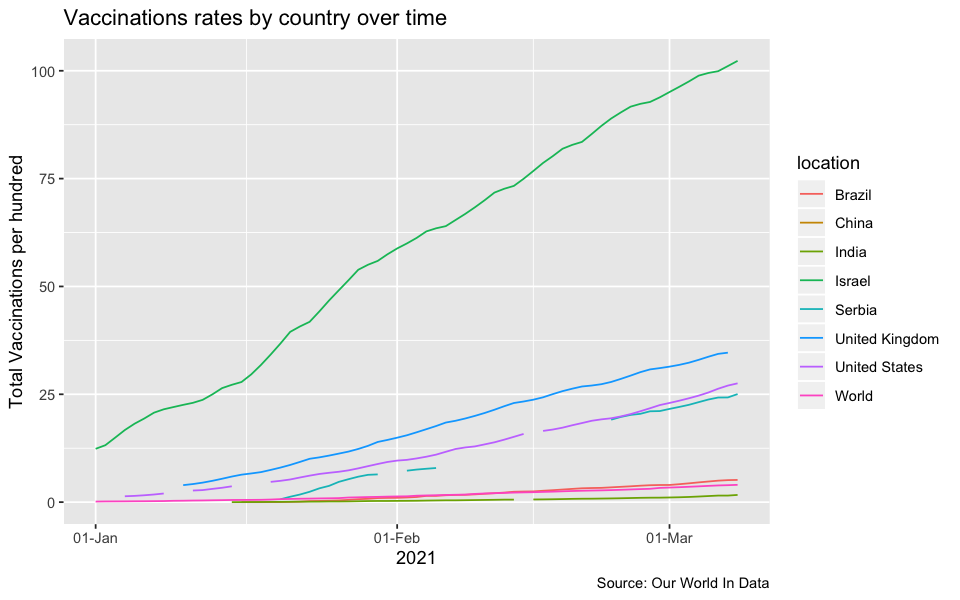

In [64]:
options(repr.plot.width=8, repr.plot.height=5)
ggplot(data=df_formatted) +
    aes(x=date_formatted, y=total_vaccinations_per_hundred, group=location, color=location)+ 
    geom_line() +
    scale_x_date(date_breaks = "1 month", labels = date_format("%d-%b")) + 
    labs(y="Total Vaccinations per hundred", x="2021", title="Vaccinations rates by country over time", caption="Source: Our World In Data")

## Vaccination rates by country

### Filter and format the data

For each of the countries we want to show, we'll want to find out the highest value of `total_vaccinations_per_hundred`.

In [58]:
df_max_vax_rate <- df_csv %>%
    # Reduce to just the columns that we want
    select(iso_code, location, date, total_vaccinations_per_hundred) %>%
    # Format the dates as actual dates, rather than strings
    mutate(date_formatted = ymd(date)) %>%
    # Cut out any dates before 2021
    filter(date_formatted > "2020-12-31") %>%
    # Cut out any country that's not in the list
    subset( location %in% countries_to_show) %>%
    # Record the highest value of total_vaccinations_per_hundred as max_vax_rate
    group_by(location) %>%
    summarize(max_vax_rate = max(total_vaccinations_per_hundred, na.rm=T)) %>%
    # Arrange these in descending order
    arrange(-max_vax_rate)

In [59]:
df_max_vax_rate

location,max_vax_rate
Israel,102.30
United Kingdom,34.65
United States,27.54
Serbia,25.05
Brazil,5.15
World,4.01
China,3.65
India,1.67


### Plot a chart of the results

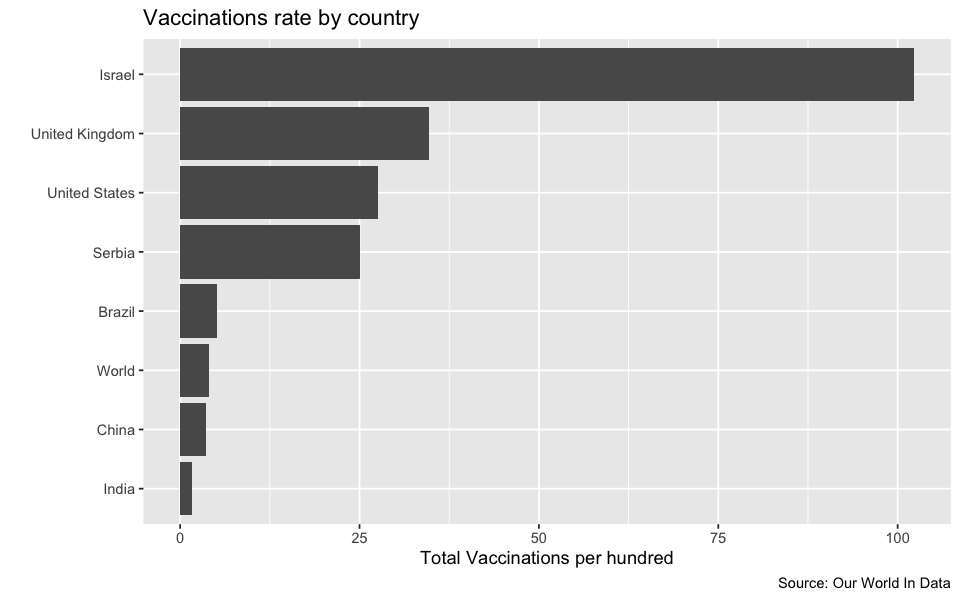

In [63]:
ggplot(df_max_vax_rate,
    aes(x = reorder(location, max_vax_rate), max_vax_rate)) +
    geom_bar(stat="identity") +
    coord_flip() +
    labs(y="Total Vaccinations per hundred", x="", title="Vaccinations rate by country", caption="Source: Our World In Data")

## New vaccinations per day

### Filter and format the data

We'll use `new_vaccinations_smoothed` to show how many vaccinations are being performed each day.

For countries that don't report per day this is smoothed to 7 days. [https://github.com/owid/covid-19-data/tree/master/public/data/vaccinations#vaccination-data]()

In [83]:
df_new_vaccinations <- df_csv %>%
    # Reduce to just the columns that we want
    select(iso_code, location, date, new_vaccinations_smoothed) %>%
    # Format the dates as actual dates, rather than strings
    mutate(date_formatted = ymd(date)) %>%
    # Cut out any dates before 2021
    filter(date_formatted > "2020-12-31") %>%
    # Remove the World count
    filter(location != "World") %>%
    # Cut out any country that's not in the list
    subset( location %in% countries_to_show)

In [79]:
head(df_new_vaccinations)

,iso_code,location,date,new_vaccinations_smoothed,date_formatted
1752,BRA,Brazil,2021-01-01,NA,2021-01-01
1753,BRA,Brazil,2021-01-02,NA,2021-01-02
1754,BRA,Brazil,2021-01-03,NA,2021-01-03
1755,BRA,Brazil,2021-01-04,NA,2021-01-04
1756,BRA,Brazil,2021-01-05,NA,2021-01-05
1757,BRA,Brazil,2021-01-06,NA,2021-01-06


### Draw the chart

Warning message:
“Removed 48 rows containing missing values (geom_path).”

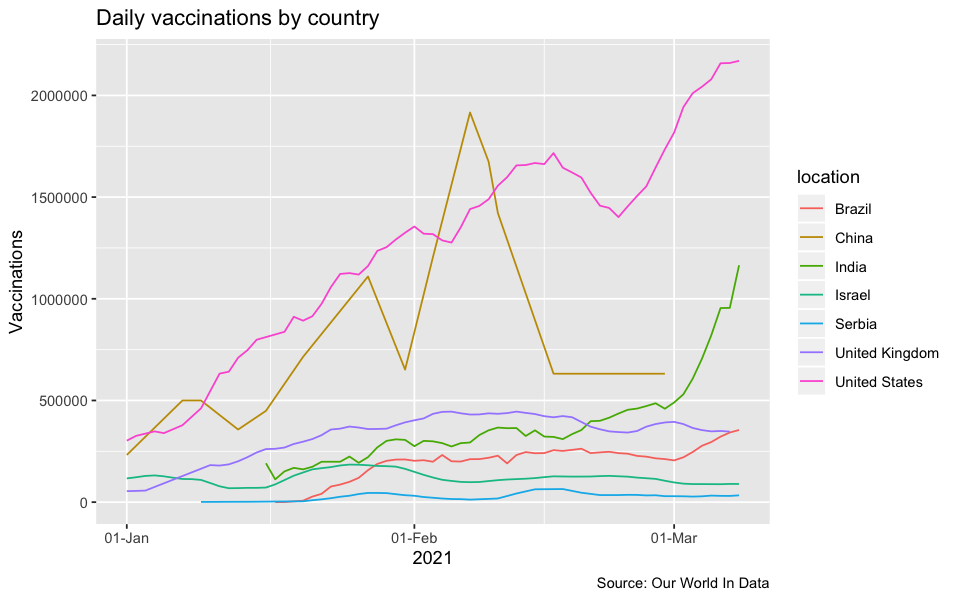

In [85]:
ggplot(df_new_vaccinations) +
    aes(x=date_formatted, y=new_vaccinations_smoothed, group=location, color=location)+ 
    geom_line() +
    scale_x_date(date_breaks = "1 month", labels = date_format("%d-%b")) + 
    labs(y="Vaccinations", x="2021", title="Daily vaccinations by country", caption="Source: Our World In Data")